# Template Repository for Research Papers with Python Code

Main Code to reproduce the results in the paper

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from dataset import OnsetDataset
from metrics import cosine_distance
from signal_processing import OnsetPreProcessor
from model_selection import PredefinedTrainValidationTestSplit
import numpy as np
from joblib import dump, load
import pandas as pd

from pyrcn.echo_state_network import ESNRegressor
from pyrcn.model_selection import SequentialSearchCV

In [2]:
sns.set_theme()
%matplotlib inline

To suppress functionality, you can easily deactivate these options

In [3]:
plot=True
export=True

At first, we load the training dataset

In [4]:
pre_processor = OnsetPreProcessor()
dataset = OnsetDataset(
    path=r"C:\Users\Steiner\Documents\Python\onset_detection\data",
    audio_suffix=".flac")
X, y = dataset.return_X_y(pre_processor=pre_processor)
test_fold = np.zeros(shape=X.shape)
start_idx = 0
for k, fold in enumerate(dataset.folds):
    test_fold[start_idx:start_idx + len(fold)] = k
    start_idx += len(fold)
cv_vali = PredefinedTrainValidationTestSplit(test_fold=test_fold)
cv_test = PredefinedTrainValidationTestSplit(test_fold=test_fold,
                                             validation=False)

In case a pre-trained model is available, we can load this.

If not, we train our model. If desired, we serialize the model.

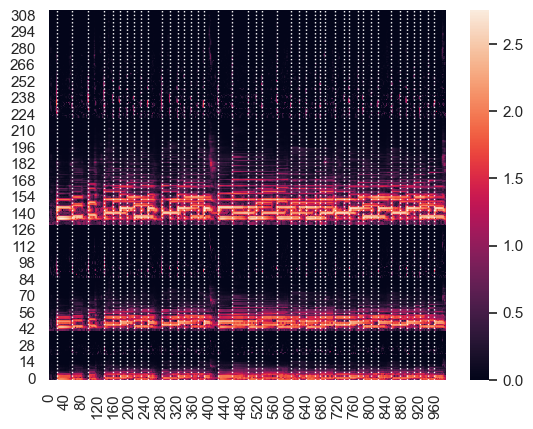

In [36]:
if plot:
    fig, axs = plt.subplots()
    # create seabvorn heatmap with required labels
    sns.heatmap(data=X[0].T, ax=axs, square=False)
    axs.invert_yaxis()
    [axs.axvline(x=ann*100, color='w', linestyle=':', linewidth=1) for ann in dataset.annotations[0]]

In [40]:
initial_esn_params = {
    'hidden_layer_size': 50, 'k_in': 10, 'input_scaling': 0.4,
    'input_activation': 'identity', 'bias_scaling': 0.0,
    'spectral_radius': 0.0, 'leakage': 1.0, 'k_rec': 10,
    'reservoir_activation': 'tanh', 'bidirectional': False,
    'alpha': 1e-5, 'random_state': 42}

base_esn = ESNRegressor(**initial_esn_params)
# Run model selection
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                'spectral_radius': uniform(loc=0, scale=2)}
step2_params = {'leakage': uniform(loc=1e-2, scale=0.99)}
step3_params = {'bias_scaling': uniform(loc=0, scale=2)}

kwargs_step1 = {
    'n_iter': 200, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}
kwargs_step2 = {
    'n_iter': 50, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}
kwargs_step3 = {
    'n_iter': 50, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}

searches = [
    ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
    ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
    ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]

try:
    search = load(f'../results/sequential_search_basic_esn.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(X, y)
    dump(search, f'../results/sequential_search_basic_esn.joblib')

We can visualize how bad this model performs on the training data.

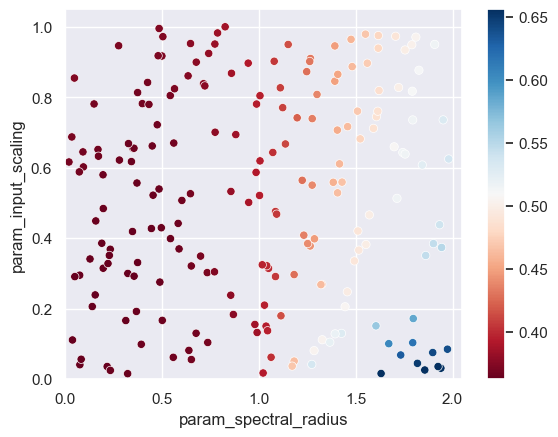

In [42]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step1"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x="param_spectral_radius", y="param_input_scaling",
                    hue="mean_test_score", ax=axs, palette="RdBu")
    
    norm = plt.Normalize(df["mean_test_score"].min(), df["mean_test_score"].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])
    plt.xlim((0, 2.05))
    plt.ylim((0, 1.05))
    # Remove the legend and add a colorbar
    axs.get_legend().remove()
    axs.figure.colorbar(sm)

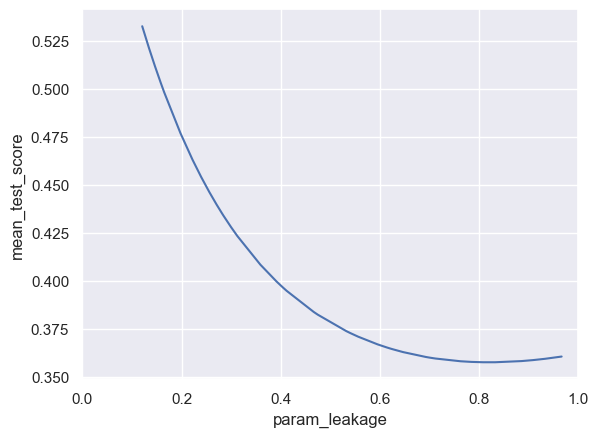

In [44]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step2"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.lineplot(data=df, x="param_leakage", y="mean_test_score", ax=axs)
    axs.set_xlim((0.0, 1.0))

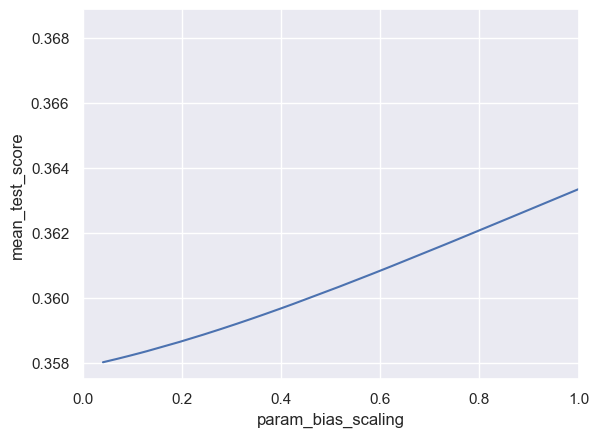

In [45]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step3"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score", ax=axs)
    axs.set_xlim((0.0, 1.0))

Next, we load the test dataset, scale it using the fitted scaler and predict the house prices.

In [38]:
import madmom

array([ 20,  58,  99, 138, 159, 176, 229, 245, 280, 300, 320, 371, 385,
       421, 456, 496, 530, 567, 639, 663, 675, 713, 734, 747, 769, 803,
       819, 852, 873, 889, 909, 944, 959, 980], dtype=int64)

In [46]:
y_pred = search.predict(X)

We can visualize how bad this model performs on the test data.

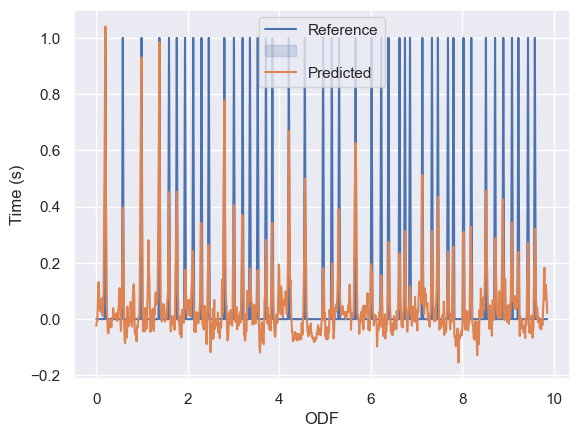

In [47]:
if plot:
    fig, axs = plt.subplots()
    sns.lineplot(x=np.arange(len(y[0])) / 100, y=y[0], ax=axs)
    sns.lineplot(x=np.arange(len(y_pred[0])) / 100, y=y_pred[0], ax=axs)
    plt.xlabel("Time (s)")
    plt.ylabel("ODF")
    axs.legend(("Reference", None, "Predicted"))

In [62]:
def evaluate_onsets(predictions, annotations):
    evals = []
    for ann, det in zip(annotations, predictions):
        e = madmom.evaluation.onsets.OnsetEvaluation(
            det, ann, combine=0.03, window=0.025)
        evals.append(e)
    se = madmom.evaluation.onsets.OnsetSumEvaluation(evals)
    me = madmom.evaluation.onsets.OnsetMeanEvaluation(evals)
    return se, me

Finally, we export our results if desired.

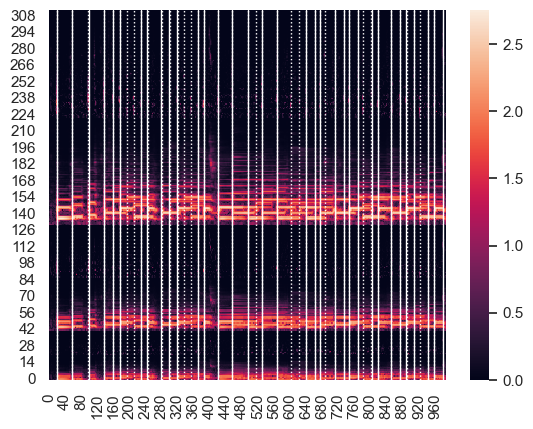

In [39]:
if plot:
    fig, axs = plt.subplots()
    # create seabvorn heatmap with required labels
    sns.heatmap(data=X[0].T, ax=axs, square=False)
    axs.invert_yaxis()
    [axs.axvline(x=ann*100, color='w', linestyle=':', linewidth=1) for ann in dataset.annotations[0]]
    [axs.axvline(x=pred, color='w', linestyle='-', linewidth=1) for pred in onsets]

In [ ]:
from sklearn.base import clone


for train_index, test_index in cv_test.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    esn = clone(search.best_estimator_).fit(X_train, y_train)
    y_train_pred = esn.predict(X_train)
    y_test_pred = esn.predict(X_test)
    for thr in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0):
        print(thr)
        rnn_peak_picking = madmom.features.onsets.OnsetPeakPickingProcessor(
            threshold=thr, pre_max=0.01, post_max=0.01, smooth=0.07, combine=0.03)
        detections = [rnn_peak_picking(act) for act in y_train_pred]
        annotations = [ann for ann in np.asarray(dataset.annotations, dtype=object)[train_index]]
        se, me = evaluate_onsets(detections, annotations)
        print(se)
        print(me)
        detections = [rnn_peak_picking(act) for act in y_test_pred]
        annotations = [ann for ann in np.asarray(dataset.annotations, dtype=object)[test_index]]
        se, me = evaluate_onsets(detections, annotations)
        print(se)
        print(me)

0.1
sum for 280 files
  Onsets: 24424 TP: 20796 FP: 25589 FN:  3628 Precision: 0.448 Recall: 0.851 F-measure: 0.587 mean:   0.2 ms std:   8.7 ms
mean for 280 files
  Onsets: 87.23 TP: 74.27 FP: 91.39 FN: 12.96 Precision: 0.474 Recall: 0.861 F-measure: 0.584 mean:  -0.6 ms std:   7.8 ms
sum for 41 files
  Onsets:  1403 TP:  1296 FP:  2133 FN:   107 Precision: 0.378 Recall: 0.924 F-measure: 0.536 mean:  -0.0 ms std:   8.0 ms
mean for 41 files
  Onsets: 34.22 TP: 31.61 FP: 52.02 FN:  2.61 Precision: 0.439 Recall: 0.923 F-measure: 0.562 mean:  -0.3 ms std:   6.5 ms
0.2
sum for 280 files
  Onsets: 24424 TP: 20231 FP: 18328 FN:  4193 Precision: 0.525 Recall: 0.828 F-measure: 0.642 mean:   0.2 ms std:   8.6 ms
mean for 280 files
  Onsets: 87.23 TP: 72.25 FP: 65.46 FN: 14.97 Precision: 0.542 Recall: 0.844 F-measure: 0.636 mean:  -0.6 ms std:   7.7 ms
sum for 41 files
  Onsets:  1403 TP:  1276 FP:  1338 FN:   127 Precision: 0.488 Recall: 0.909 F-measure: 0.635 mean:  -0.1 ms std:   8.0 ms
mean 